In [1]:
import numpy as np
from torch.autograd import Variable
import torch
import random
from typing import List, Callable
import matplotlib.pyplot as plt
import time

seed = 999
torch.manual_seed(seed)
random.seed(seed)

/opt/homebrew/Caskroom/miniconda/base/envs/dlcv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gradient-Filter-based Distributed Gradient Descent

In [9]:

def CGEFilter(gradients: List[torch.Tensor], n: int, f: int):
    assert (f <= n)
    tmp = sorted(gradients, key=lambda x: x.norm())
    return sum(tmp[:n-f])


def decision(p):
    '''Make the decision with probability p'''
    return random.random() < p




In [15]:
agents_cost = [
    lambda X: sum((X-1000)**2),
    lambda X: sum((X-5)**2),
    lambda X: sum((X+7)**2),
    lambda X: sum(X**2) - sum(X),
    lambda X: X[0]**2+X[-1]**2,
    # lambda X: sum(torch.cos(X)),
]


dim = 10 # dimension of x
step_size = 0.1 # Eta
num_agents = len(agents_cost) # number of agents
num_faulty = 0 # current number of faulty agents
max_num_faulty = num_agents - 2
fault_rate = 0.0


X = torch.randint(low=-10000, high=10000, size=(dim, )).to(torch.float)
# X = torch.rand((dim, ))
losses = []
for _ in range(10):
    time.sleep(0.5)
    gradients = []
    faulty_agents = []
    X = Variable(X, requires_grad=True)
    for i, cost in enumerate(agents_cost):
        if cost is None:
            continue
        y = cost(X)
        y.backward()
        is_failed = decision(fault_rate)
        if num_faulty < max_num_faulty and is_failed:
            num_faulty += 1
            faulty_agents.append(i)
        else:
            gradients.append(X.grad.clone())
        X.grad.zero_()
    
    for index in faulty_agents:
        agents_cost[index] = None
        
    if len(faulty_agents) > 0:
        print("\nfaulty agents:", faulty_agents)
    
    new_grad = CGEFilter(gradients, num_agents, num_faulty)
    X = X.data - step_size*new_grad
    step_size *= 0.98 # diminishing step size

    loss = 0.0
    for cost in agents_cost:
        if cost is not None:
            loss += cost(X)
    print(f'step: {_} | loss: {loss.item():4f} | grad norm: {new_grad.norm().item():4f} | step size: {step_size:6f}', end='\r')
    losses.append(loss.item())

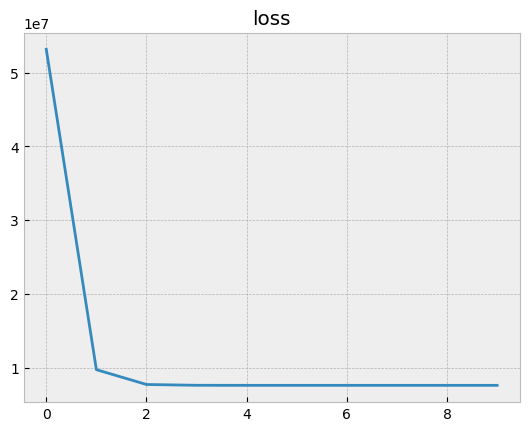

In [16]:
plt.style.use('bmh')
plt.plot(losses)
plt.title('loss')
plt.show()

## Linearization Method

In [2]:
import scipy.optimize as opt
from scipy.optimize import LinearConstraint, NonlinearConstraint, Bounds

In [3]:
def Gradient(func: Callable, X: torch.Tensor):
    tmp = Variable(X, requires_grad=True)
    try:
        func(tmp).backward()
        grad = tmp.grad.clone().data
        return grad
    # the zero constraint function would throw
    except AttributeError as err:
        if func(tmp) != 0.0:
            raise(err)
        return torch.zeros(X.shape)

In [241]:
'''
δ, subscript of I(X), should be non-negative
inf implies I_δ(X) == I(X)
'''
DELTA = torch.inf 
N = 1
EPSILON = 0.5



In [327]:
obj = lambda X: X[0]*X[1]+1  # x*y + 1
cons =[
    lambda X: sum(X**2) - 1,   # x^2 + y^2 + 1
    lambda X: abs(X[0]) + abs(X[1]) - 1,
    lambda X: X[0]**3 + X[1]**2, # x^3 + y^2
    lambda X: 0.0, # the assumption on the top of page 44
]

# initial guess
# X = torch.randint(low=-200, high=200, size=(2, )).to(torch.float)
# X = torch.Tensor([300.0, -200.0])
X = torch.Tensor([30.0, -20.0])
print(X)

# real answer
res = opt.minimize(obj, X, constraints=[NonlinearConstraint(i, -torch.inf, 0) for i in cons])
res

tensor([ 30., -20.])


     fun: 0.9999997127214766
     jac: array([-0.00018913,  0.00389484])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([ 0.00237873, -0.00012077])

In [328]:
# Our ans
positions = [X]
num_iterate = 50
for _ in range(num_iterate):
    '''Find I_δ(X)'''
    F = lambda X: max([f(X) for f in cons])
    I_delta = []
    for i, f_i in enumerate(cons):
        if f_i(X) >= F(X) - DELTA:
            I_delta.append(i)
    '''approximate objective'''
    quad_obj = lambda p: np.dot(Gradient(obj, X), p) + 0.5*np.dot(p, p)

    '''approximate constrants'''
    grad_of_cons = []
    val_of_cons = []
    for i in I_delta:
        val_of_cons.append(cons[i](X))
        grad_of_cons.append(Gradient(cons[i], X))

    # linear_cons = [np.dot(grad, p) + val for grad, val in zip(grad_of_cons, val_of_cons)]

    res = opt.minimize(quad_obj, X, constraints=[LinearConstraint(grad, -np.inf, -val) for grad, val in zip(grad_of_cons, val_of_cons)])
    if not res.success:
        print(res)
        raise(BaseException)
    p = (res.x) # solution of the quadratic programming problem

    alpha = 1
    while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
        alpha /= 2

    X += alpha*p
    positions.append(X)
    print(f'X: ({X[0]:4f}, {X[1]:4f}), obj: {obj(X)}, alpha: {alpha}, |p|: {sum(p**2):4f}', end='\r')
    time.sleep(.1)


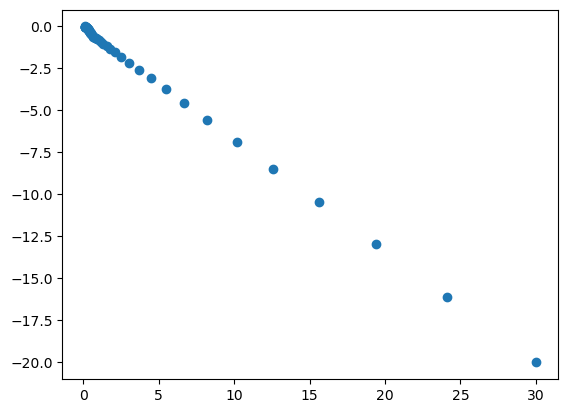

In [326]:
# positions = positions[3:]
plt.scatter([pos[0] for pos in positions],[ pos[1] for pos in positions])
plt.show()

In [195]:
torch.exp(torch.from_numpy(np.array([1, 2])))

tensor([2.7183, 7.3891])